<a href="https://colab.research.google.com/github/Luiza122/Sprint_dynamic/blob/main/Sprint4_Dynamic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧪 Sprint 4 — Dynamic Programming (Hospital Supplies)

**Integrantes**  
- Fernanda Menon — RM 554673  
- Gabriel Machado Lacerda — RM 556714  
- Luiza Macena Dantas — RM 556237  
- Roger Cardoso Ferreira — RM 557230

2ESPW

Este notebook implementa uma solução de **Programação Dinâmica** para planejar consumo/reabastecimento de **insumos hospitalares** (reagentes e descartáveis), reduzindo **desperdício** e **custos** e aumentando a **visibilidade** do consumo diário.



## 1) Formulação do Problema

- **Estado**: início de um dia `t` com estoque efetivo **zerado** daquele insumo (ponto de decisão).  
- **Decisão**: fazer **um pedido** no dia `t` para cobrir a demanda de `t..k` (inclusive), com limite de validade \(L\): `t ≤ k ≤ min(t+L-1, N)`.  
- **Transição**: após cobrir `t..k` com o pedido, avançamos para o próximo ponto de decisão no dia `k+1` com estoque zerado.  
- **Função Objetivo**: **minimizar** o custo total (nº de pacotes * custo por pacote). Toda sobra dentro do último pacote de cada pedido é considerada **desperdício**.

**Parâmetros**  
- `demandas[d]`: demanda do dia `d` (1-indexado no modelo).  
- `pack_size`: unidades por pacote do insumo.  
- `L`: validade do pacote aberto em **dias**.  
- `custo_pacote`: custo de 1 pacote (podemos assumir 1 para minimizar quantidade de pacotes).


In [1]:

from math import ceil
from functools import lru_cache
from typing import List, Tuple, Dict
import random

def prefix_sum(arr: List[int]) -> List[int]:
    """Retorna prefixos para somas rápidas: S[0]=0; S[i]=sum(arr[:i])."""
    S = [0]
    for x in arr:
        S.append(S[-1] + x)
    return S

def intervalo_soma(S: List[int], i: int, j: int) -> int:
    """Soma arr[i-1..j-1] com prefixos S (1-indexado nos índices i..j)."""
    return S[j] - S[i-1]


## 2) Abordagem Recursiva com Memoização (Top-Down) — custo e política

In [2]:

def dp_topdown(demandas: List[int], L: int, pack_size: int, custo_pacote: float = 1.0):
    N = len(demandas)
    S = prefix_sum(demandas)
    escolha: Dict[int, int] = {}  # armazena k* ótimo para cada t

    @lru_cache(maxsize=None)
    def C(t: int) -> float:
        if t > N:
            return 0.0
        best = float('inf')
        best_k = t
        # tentar cobrir do t até k, respeitando validade
        for k in range(t, min(t + L - 1, N) + 1):
            demanda_intervalo = intervalo_soma(S, t, k)
            pacotes = ceil(demanda_intervalo / pack_size) if demanda_intervalo > 0 else 0
            custo_pedido = pacotes * custo_pacote
            total = custo_pedido + C(k + 1)
            if total < best:
                best = total
                best_k = k
        escolha[t] = best_k
        return best

    custo_min = C(1)

    # Reconstrução da política ótima: lista de (inicio, fim, pacotes)
    politica = []
    t = 1
    while t <= N:
        k = escolha[t]
        demanda_intervalo = intervalo_soma(S, t, k)
        pacotes = ceil(demanda_intervalo / pack_size) if demanda_intervalo > 0 else 0
        politica.append((t, k, pacotes))
        t = k + 1

    return custo_min, politica


## 3) Abordagem Iterativa (Bottom-Up) — custo e política

In [3]:

def dp_bottomup(demandas: List[int], L: int, pack_size: int, custo_pacote: float = 1.0):
    N = len(demandas)
    S = prefix_sum(demandas)
    C = [0.0] * (N + 2)  # C[i] = custo ótimo do dia i..N
    prox = [0] * (N + 2) # prox[i] = k ótimo para o intervalo [i..k]

    for i in range(N, 0, -1):
        best = float('inf')
        best_k = i
        for k in range(i, min(i + L - 1, N) + 1):
            demanda_intervalo = intervalo_soma(S, i, k)
            pacotes = ceil(demanda_intervalo / pack_size) if demanda_intervalo > 0 else 0
            custo_pedido = pacotes * custo_pacote
            total = custo_pedido + C[k + 1]
            if total < best:
                best = total
                best_k = k
        C[i] = best
        prox[i] = best_k

    custo_min = C[1]
    # Reconstrução da política
    politica = []
    t = 1
    while t <= N:
        k = prox[t]
        demanda_intervalo = intervalo_soma(S, t, k)
        pacotes = ceil(demanda_intervalo / pack_size) if demanda_intervalo > 0 else 0
        politica.append((t, k, pacotes))
        t = k + 1

    return custo_min, politica


## 4) Métricas de saída e visualização textual

In [8]:

def resumo_politica(demandas: List[int], pack_size: int, L: int, politica: List[tuple]):
    N = len(demandas)
    S = prefix_sum(demandas)
    total_pacotes = 0
    total_consumo = sum(demandas)
    total_sobra = 0

    linhas = []
    for (t, k, pacotes) in politica:
        consumo_intervalo = intervalo_soma(S, t, k)
        sobra = pacotes * pack_size - consumo_intervalo
        total_pacotes += pacotes
        total_sobra += max(0, sobra)
        linhas.append(f"Pedido em t={t} cobrindo até k={k} | Demanda={consumo_intervalo} | Pacotes={pacotes} | Sobra={max(0, sobra)}")

    txt = "\n".join(linhas)
    return {
        "pacotes": total_pacotes,
        "consumo": total_consumo,
        "sobra": total_sobra,
        "linhas": txt
    }

def pretty_print(demandas, pack_size, L, resultado, titulo="Resultado"):
    custo, politica = resultado
    met = resumo_politica(demandas, pack_size, L, politica)
    print(f"=== {titulo} ===")
    print(f"Demanda total: {met['consumo']}  | Pack size: {pack_size}  | Validade L: {L} dias")
    print(met["linhas"])
    print(f"Pacotes totais: {met['pacotes']}  | Sobra total (desperdício): {met['sobra']}")
    print(f"Custo mínimo total (em unidades de custo) = {custo}\n")


## 5) Experimentos — Comparação Top-Down vs Bottom-Up

In [5]:

# Exemplo fixo (como no texto): 5 dias, demanda de 2 por dia, pack de 10, L=3
demandas = [2,2,2,2,2]
pack_size = 10
L = 3
custo_top, pol_top = dp_topdown(demandas, L, pack_size)
custo_bot, pol_bot = dp_bottomup(demandas, L, pack_size)

pretty_print(demandas, pack_size, L, (custo_top, pol_top), titulo="Top-Down")
pretty_print(demandas, pack_size, L, (custo_bot, pol_bot), titulo="Bottom-Up")

assert custo_top == custo_bot, "Os custos ótimos devem coincidir!"
assert pol_top == pol_bot, "A política ótima reconstruída deve ser a mesma!"

# Experimento aleatório reprodutível
random.seed(42)
demandas_rand = [random.randint(0, 12) for _ in range(14)]  # 2 semanas
pack_size = 10
L = 4

custo_top2, pol_top2 = dp_topdown(demandas_rand, L, pack_size)
custo_bot2, pol_bot2 = dp_bottomup(demandas_rand, L, pack_size)

pretty_print(demandas_rand, pack_size, L, (custo_top2, pol_top2), titulo="Top-Down (Aleatório)")
pretty_print(demandas_rand, pack_size, L, (custo_bot2, pol_bot2), titulo="Bottom-Up (Aleatório)")

assert custo_top2 == custo_bot2
assert pol_top2 == pol_bot2


=== Top-Down ===
Demanda total: 10  | Pack size: 10  | Validade L: 3 dias
Pedido em t=1 cobrindo até k=2 | Demanda=4 | Pacotes=1 | Sobra=6
Pedido em t=3 cobrindo até k=5 | Demanda=6 | Pacotes=1 | Sobra=4
Pacotes totais: 2  | Sobra total (desperdício): 10
Custo mínimo total (em unidades de custo) = 2.0

=== Bottom-Up ===
Demanda total: 10  | Pack size: 10  | Validade L: 3 dias
Pedido em t=1 cobrindo até k=2 | Demanda=4 | Pacotes=1 | Sobra=6
Pedido em t=3 cobrindo até k=5 | Demanda=6 | Pacotes=1 | Sobra=4
Pacotes totais: 2  | Sobra total (desperdício): 10
Custo mínimo total (em unidades de custo) = 2.0

=== Top-Down (Aleatório) ===
Demanda total: 76  | Pack size: 10  | Validade L: 4 dias
Pedido em t=1 cobrindo até k=1 | Demanda=10 | Pacotes=1 | Sobra=0
Pedido em t=2 cobrindo até k=2 | Demanda=1 | Pacotes=1 | Sobra=9
Pedido em t=3 cobrindo até k=3 | Demanda=0 | Pacotes=0 | Sobra=0
Pedido em t=4 cobrindo até k=6 | Demanda=18 | Pacotes=2 | Sobra=2
Pedido em t=7 cobrindo até k=10 | Demanda=1


## 6) Como usar com dados reais da farmácia/diagnóstico

Substitua a lista `demandas` por uma série diária real (por item), ajuste `pack_size` e `L` conforme o insumo (por exemplo, kit de reagente com 10 testes e validade de 3 dias após aberto).  
O algoritmo devolve a **política ótima** de agrupamento de dias por pedido, reduzindo **aberturas desnecessárias** e **desperdício**.

> Dica: gere uma planilha `.csv` com colunas `data, demanda` e faça o parse em Python para montar a lista de demandas do período.



## 7) Conclusões

- Modelamos o planejamento diário como um problema sequencial com **estado, decisão, transição e função objetivo**.  
- Implementamos **duas abordagens** (top-down com memoização e bottom-up) e verificamos que retornam **o mesmo resultado**.  
- Reportamos **política ótima**, **nº de pacotes** e **desperdício total**, trazendo **visibilidade** para tomada de decisão e reduzindo custos.



## 8) Visualizações (matplotlib)

Os gráficos abaixo reforçam a visibilidade do consumo e do desperdício:
1. **Demanda diária** (barras)  
2. **Desperdício por intervalo de pedido** (barras)  
3. **Pacotes acumulados vs. dias** (linha)  
4. **Linha do tempo dos pedidos** (marcadores de início/fim)


In [6]:
import matplotlib.pyplot as plt

def graficos_visibilidade(demandas, pack_size, L, politica, titulo_prefixo="Cenário"):
    # 1) Demanda diária
    plt.figure()
    plt.bar(range(1, len(demandas)+1), demandas)
    plt.title(f"{titulo_prefixo}: Demanda diária")
    plt.xlabel("Dia")
    plt.ylabel("Demanda (unidades)")
    plt.show()

    # 2) Desperdício por intervalo de pedido
    from math import ceil
    from itertools import count

    desperdicios = []
    labels = []
    idx = count(1)
    S_total = sum(demandas)

    # calcula sobra por intervalo
    for (t, k, pacotes) in politica:
        consumo = sum(demandas[t-1:k])
        sobra = max(0, pacotes*pack_size - consumo)
        desperdicios.append(sobra)
        labels.append(f"{next(idx)}: {t}-{k}")

    plt.figure()
    plt.bar(labels, desperdicios)
    plt.title(f"{titulo_prefixo}: Desperdício por pedido (sobra)" )
    plt.xlabel("Intervalo de cobertura (pedido)")
    plt.ylabel("Sobra (unidades)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3) Pacotes acumulados ao longo dos dias
    pacotes_acum = []
    total = 0
    # marca pacotes por início de pedido
    start_days = set(t for (t,_,p) in politica for _ in range(1))
    for d in range(1, len(demandas)+1):
        if d in start_days:
            # soma pacotes iniciados neste dia
            p_dia = sum(p for (t,k,p) in politica if t==d)
            total += p_dia
        pacotes_acum.append(total)

    plt.figure()
    plt.plot(range(1, len(demandas)+1), pacotes_acum, marker='o')
    plt.title(f"{titulo_prefixo}: Pacotes acumulados por dia")
    plt.xlabel("Dia")
    plt.ylabel("Pacotes acumulados")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

    # 4) Linha do tempo dos pedidos (início e fim)
    start = [t for (t,_,_) in politica]
    end   = [k for (_,k,_) in politica]

    plt.figure()
    plt.stem(start, [1]*len(start))
    plt.stem(end,   [1]*len(end))
    plt.title(f"{titulo_prefixo}: Início (t) e Término (k) dos pedidos")
    plt.xlabel("Dia")
    plt.ylabel("Marcador (1)")
    plt.show()

### 8.1) Rodando gráficos para os cenários já usados nos experimentos

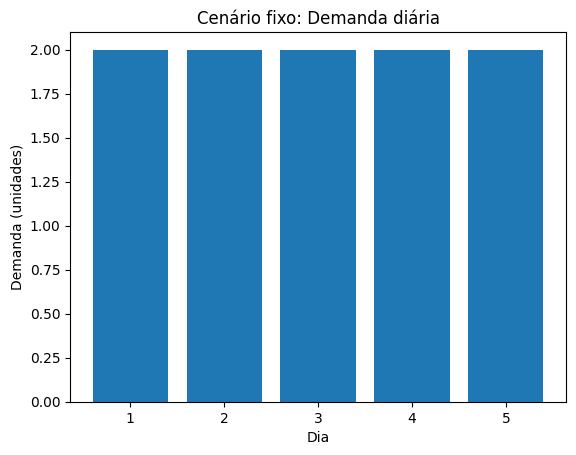

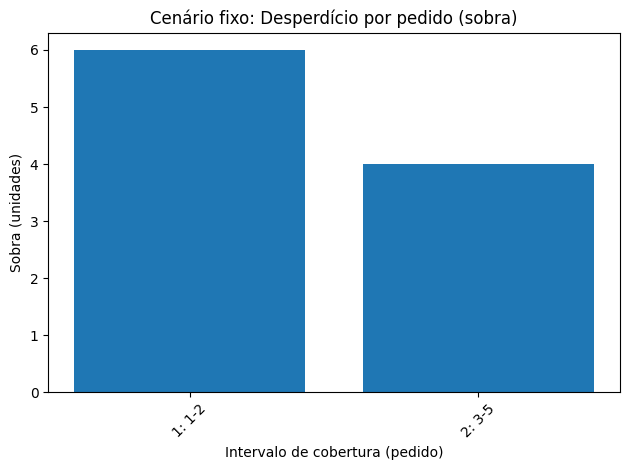

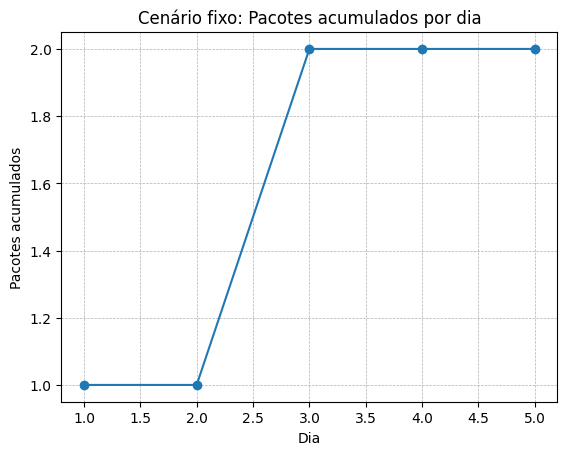

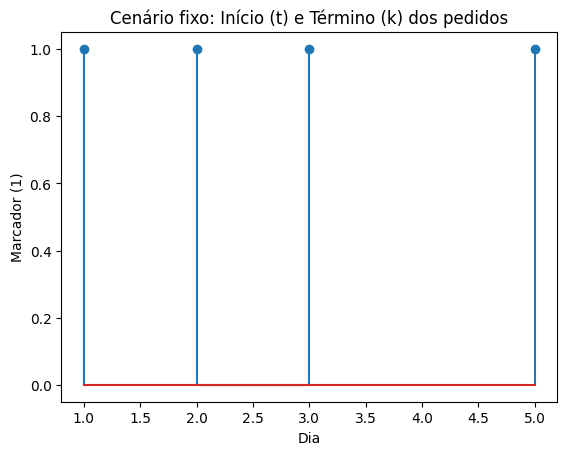

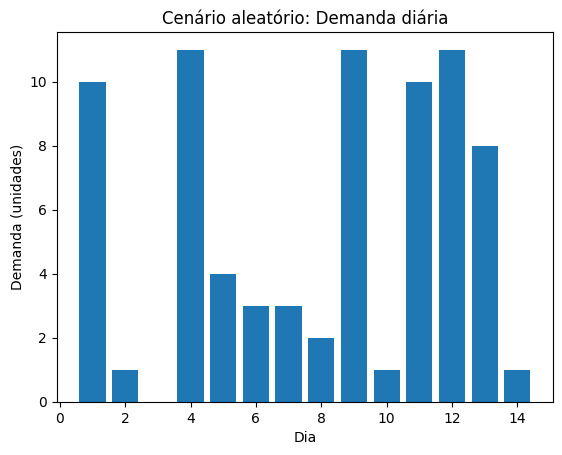

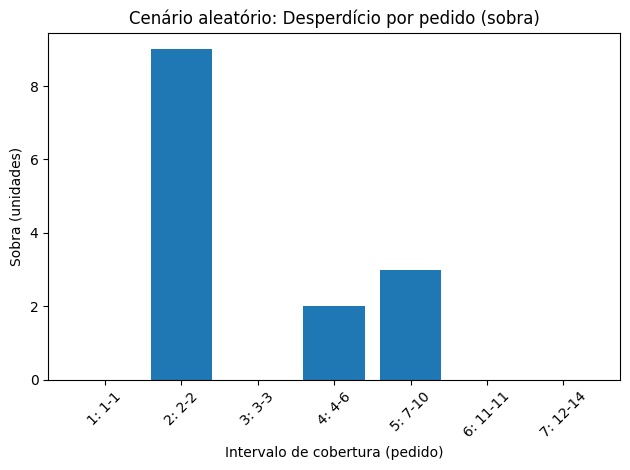

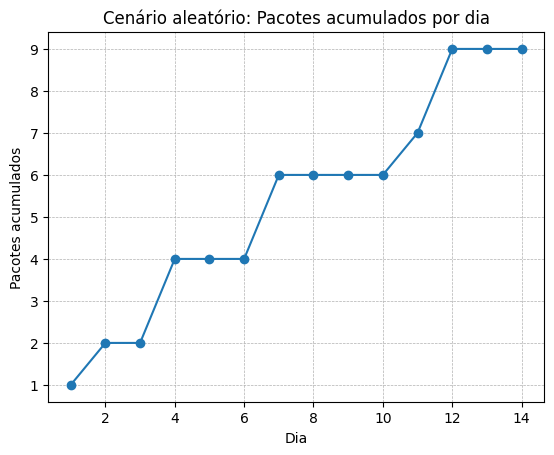

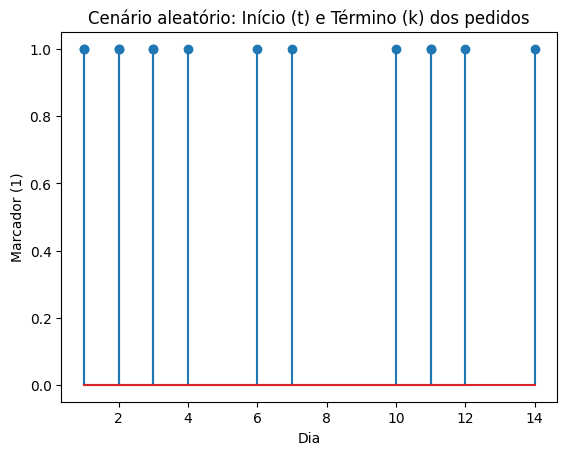

In [7]:

# Cenário fixo
demandas_fix = [2,2,2,2,2]
pack_size_fix = 10
L_fix = 3
custo_fix, pol_fix = dp_bottomup(demandas_fix, L_fix, pack_size_fix)
graficos_visibilidade(demandas_fix, pack_size_fix, L_fix, pol_fix, titulo_prefixo="Cenário fixo")


# Cenário aleatório (mesmo do experimento)
import random
random.seed(42)
demandas_rand = [random.randint(0, 12) for _ in range(14)]
pack_size = 10
L = 4
custo_r, pol_r = dp_bottomup(demandas_rand, L, pack_size)
graficos_visibilidade(demandas_rand, pack_size, L, pol_r, titulo_prefixo="Cenário aleatório")
